# The Nh5 DST

## Monte Carlo PRD (Pre-Raw Data)

### What is PRD

To simulate properly the response of the energy plane (EP), e.g, the effect of the HPF and LPF introduced by the FEE, it is necessary to generate MC data in bins of time much thinner that those produced by the DAQ (in practice one would like to generate a continuous signal which is first transformed by the filters and then decimated by the DAQ). Therefore, the PRD consists of a train of photoelectrons in bins of 1 ns (the DAQ runs at 25 ns) for each PMT.

Since the DAQ window is large (at least 600 mus), this implies that one needs to store waveforms of 600,000 integers, most of which are filled with zeros (the signal is quite sparse). This makes obvious the need for compression. HDF5 allows severals compressors, including blosc and zlib. 

PRD is the input to ISIDORA which outputs the waveforms after FEE and DAQ. Those waveforms have 24000 integers and are therefore much smaller. The output of ISIDORA is Raw Data (RD). 

In [5]:
from __future__ import print_function

In [7]:
pmt_wf_bins = 600000
sipm_wf_bins = 600
int_size_bytes = 4
n_pmt = 12
n_sipm = 1792
pmt_wf_MB =n_pmt*pmt_wf_bins*int_size_bytes/1e+6
sipm_wf_MB  =n_sipm*sipm_wf_bins*int_size_bytes/1e+6
prd_size = pmt_wf_MB +sipm_wf_MB
print("pmt WF (MB) = {}, sipm Wf (MB) = {}, total = {} MB ".format(pmt_wf_MB,sipm_wf_MB,prd_size))


pmt WF (MB) = 28.8, sipm Wf (MB) = 4.3008, total = 33.1008 MB 


Thus the PRD needs 33 MB per event! The ROOT DST's produced by CENTELLA/GATE are of the order of 1 GB per 100 events, therefore they are somewhat compressed. However, one can do much better, since most of the waveforms are ceros. The hdf5 files compressed by Zlib can be as small as 10 MB per 100 events (thus 2 orders of magnitude reduction wrt root) but in exchange access is rather slow. Even with minimum compression (1), the size is 25 MB per 100 events (thus reduction of 40) and the access is faster. BLOSC produces also files of 25 MB and even faster access.

### Test Bench

As a test bench we execute the function pmt_energy_pes, defined below. The function consists on a loop over the 12 PMTs, loading each WF and adding their contents to compute the total sum

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import tables as tb
import numpy as np

In [8]:
 a = np.zeros((4,5))

In [9]:
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [55]:
def pmt_energy_pes(pfile, nevents=1):
    """
    Creates a DF for the PMTs with the energy of each sensor in PES
    """
    with tb.open_file(pfile, "r") as h5in:
        
        pmtrd_ = h5in.root.pmtrd #pointer to the EARRAY holding the data
        print("pmtrd_ shape = {}".format(pmtrd_.shape))
        
        nev = min(nevents,pmtrd_.shape[0])
        npmt = pmtrd_.shape[1]
        print("number of PMTs = {}".format(npmt))
        print("running over {} events".format(nev))
        
        ene_pes = np.zeros((nevents,npmt))
        print("shape of ene_pes ={}".format(ene_pes.shape))
        for i in range(nev):
            for j in range(npmt):
                pmtrd = pmtrd_[i, j]
                ene = sum(pmtrd)
                ene_pes[i,j] = ene
            
         
    return pd.DataFrame(ene_pes)

### Blosc compressed file

In [12]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'

In [14]:
%ls /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/

1ns/               WF_Kr_0.h5         WF_Tl_1100evts.h5
25ns/              WF_Na_0.h5         root/
NA-zlib/           WF_Tl_0.h5         test.h5


In [15]:
ffile = 'WF_Na_0.h5' #BLOSC compressed

In [17]:
%time ene = pmt_energy_pes(path+ffile, nevents=1)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 1 events
CPU times: user 29.8 ms, sys: 4.16 ms, total: 34 ms
Wall time: 35.4 ms


In [18]:
ene

array([[ 4475.,  4669.,  4645.,  3970.,  3943.,  3930.,  3896.,  4056.,
         3954.,  4064.,  3890.,  3958.]])

In [19]:
%time ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 10 events
CPU times: user 226 ms, sys: 15.3 ms, total: 241 ms
Wall time: 248 ms


In [20]:
ene

array([[  4475.,   4669.,   4645.,   3970.,   3943.,   3930.,   3896.,
          4056.,   3954.,   4064.,   3890.,   3958.],
       [ 20056.,  20176.,  20134.,  17003.,  17100.,  17131.,  17125.,
         17037.,  17149.,  17017.,  16944.,  16864.],
       [  3762.,   3727.,   3645.,   3232.,   3163.,   3296.,   3210.,
          3161.,   3269.,   3073.,   3150.,   3155.],
       [  4186.,   4094.,   4113.,   3475.,   3484.,   3579.,   3578.,
          3401.,   3505.,   3617.,   3522.,   3394.],
       [   361.,    356.,    375.,    341.,    318.,    281.,    301.,
           320.,    277.,    311.,    268.,    318.],
       [  4927.,   4828.,   5028.,   4253.,   4292.,   4265.,   4320.,
          4173.,   4286.,   4331.,   4378.,   4213.],
       [ 21104.,  21153.,  21024.,  18065.,  18007.,  18172.,  18217.,
         17868.,  18024.,  18188.,  17792.,  17839.],
       [  5471.,   5268.,   5460.,   4543.,   4474.,   4671.,   4499.,
          4673.,   4466.,   4551.,   4506.,   4556.],


In [21]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 183 ms per loop


In [22]:
enedf = pd.DataFrame(ene)

In [23]:
enedf

,0,1,2,3,4,5,6,7,8,9,10,11
0,4475.0,4669.0,4645.0,3970.0,3943.0,3930.0,3896.0,4056.0,3954.0,4064.0,3890.0,3958.0
1,20056.0,20176.0,20134.0,17003.0,17100.0,17131.0,17125.0,17037.0,17149.0,17017.0,16944.0,16864.0
2,3762.0,3727.0,3645.0,3232.0,3163.0,3296.0,3210.0,3161.0,3269.0,3073.0,3150.0,3155.0
3,4186.0,4094.0,4113.0,3475.0,3484.0,3579.0,3578.0,3401.0,3505.0,3617.0,3522.0,3394.0
4,361.0,356.0,375.0,341.0,318.0,281.0,301.0,320.0,277.0,311.0,268.0,318.0
5,4927.0,4828.0,5028.0,4253.0,4292.0,4265.0,4320.0,4173.0,4286.0,4331.0,4378.0,4213.0
6,21104.0,21153.0,21024.0,18065.0,18007.0,18172.0,18217.0,17868.0,18024.0,18188.0,17792.0,17839.0
7,5471.0,5268.0,5460.0,4543.0,4474.0,4671.0,4499.0,4673.0,4466.0,4551.0,4506.0,4556.0
8,8027.0,7990.0,7847.0,6776.0,6736.0,6773.0,6865.0,6728.0,6638.0,6849.0,6852.0,6724.0
9,7280.0,7179.0,7285.0,6173.0,6201.0,6117.0,6095.0,6287.0,6211.0,6058.0,6047.0,6256.0


### Zlib files

#### large chunking compression 1-9

In [24]:
%ls /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/NA-zlib/

WF_Na_0.h5                           WF_Na_0_100evts_comp3.h5
WF_Na_0_100evts_comp1.h5             WF_Na_0_100evts_comp4.h5
WF_Na_0_100evts_comp1_chunk16384.h5  WF_Na_0_100evts_comp5.h5
WF_Na_0_100evts_comp1_chunk32768.h5  WF_Na_0_100evts_comp6.h5
WF_Na_0_100evts_comp1_chunk65356.h5  WF_Na_0_100evts_comp7.h5
WF_Na_0_100evts_comp2.h5             WF_Na_0_100evts_comp8.h5
WF_Na_0_100evts_comp2_smallchunk.h5  WF_Na_0_100evts_comp9.h5


In [27]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/NA-zlib/'

In [28]:
ffile = 'WF_Na_0_100evts_comp9.h5'

In [29]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 7.37 s per loop


In [30]:
ffile = 'WF_Na_0_100evts_comp1.h5'

In [31]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 3.6 s per loop


Reducing the level of compression results in a factor 2 gain in speed and a factor 2 loss in size

In [32]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/NA-zlib/'

total 477688
-rw-r--r--  1 jjgomezcadenas  staff    23M Aug  8 16:29 WF_Na_0.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    22M Aug  8 15:17 WF_Na_0_100evts_comp1.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    25M Aug  8 17:49 WF_Na_0_100evts_comp1_chunk16384.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    24M Aug  8 16:56 WF_Na_0_100evts_comp1_chunk32768.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    24M Aug  8 16:56 WF_Na_0_100evts_comp1_chunk65356.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    21M Aug  8 15:17 WF_Na_0_100evts_comp2.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    23M Aug  8 15:26 WF_Na_0_100evts_comp2_smallchunk.h5
-rw-r--r--@ 1 jjgomezcadenas  staff    20M Aug  8 15:17 WF_Na_0_100evts_comp3.h5
-rw-r--r--@ 1 jjgomezcadenas  staff   9.3M Aug  8 15:17 WF_Na_0_100evts_comp4.h5
-rw-r--r--@ 1 jjgomezcadenas  staff   9.1M Aug  8 15:17 WF_Na_0_100evts_comp5.h5
-rw-r--r--@ 1 jjgomezcadenas  staff   8.6M Aug  8 15:17 WF_Na_0_100evts_comp6.h5
-rw-r--r--@ 1 jjgomezcadenas  staff   8.5M Aug  8 15:17 WF_Na_0_10

#### Try now to reduce chunk size

In [33]:
ffile = 'WF_Na_0_100evts_comp1_chunk65356.h5'

In [34]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 572 ms per loop


Much improvement!

In [35]:
ffile = 'WF_Na_0_100evts_comp1_chunk32768.h5'

In [36]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 307 ms per loop


In [37]:
ffile = 'WF_Na_0_100evts_comp1_chunk16384.h5'

In [38]:
%timeit ene = pmt_energy_pes(path+ffile, nevents=10)

pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
pmtrd_ shape = (100, 12, 599999)
number of PMTs = 12
running over 10 events
1 loop, best of 3: 340 ms per loop


The last reduction does not improve performance! Optimal size found for Zlib, best ~300 ms per loop

In [39]:
performance_time = pd.DataFrame({'blosc':[183],'zlib-9':[7370],'zlib-1':[3600],
                   'zlib-1-chunk64':[572],'zlib-1-chunk32':[307],'zlib-1-chunk16':[340]})

In [41]:
performance_time

,blosc,zlib-1,zlib-1-chunk16,zlib-1-chunk32,zlib-1-chunk64,zlib-9
0,183,3600,340,307,572,7370


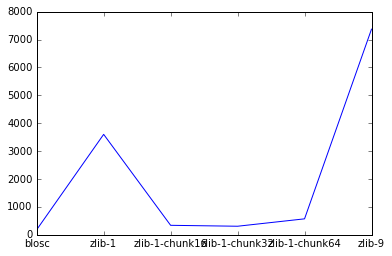

In [45]:
performance_time.ix[0].plot()

Back to blosch file

In [46]:
ffile = 'WF_Na_0.h5'
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'

In [56]:
ene = pmt_energy_pes(path+ffile, nevents=100)

pmtrd_ shape = (99, 12, 599999)
number of PMTs = 12
running over 99 events
shape of ene_pes =(100, 12)


In [57]:
ene

,0,1,2,3,4,5,6,7,8,9,10,11
0,4475.0,4669.0,4645.0,3970.0,3943.0,3930.0,3896.0,4056.0,3954.0,4064.0,3890.0,3958.0
1,20056.0,20176.0,20134.0,17003.0,17100.0,17131.0,17125.0,17037.0,17149.0,17017.0,16944.0,16864.0
2,3762.0,3727.0,3645.0,3232.0,3163.0,3296.0,3210.0,3161.0,3269.0,3073.0,3150.0,3155.0
3,4186.0,4094.0,4113.0,3475.0,3484.0,3579.0,3578.0,3401.0,3505.0,3617.0,3522.0,3394.0
4,361.0,356.0,375.0,341.0,318.0,281.0,301.0,320.0,277.0,311.0,268.0,318.0
5,4927.0,4828.0,5028.0,4253.0,4292.0,4265.0,4320.0,4173.0,4286.0,4331.0,4378.0,4213.0
6,21104.0,21153.0,21024.0,18065.0,18007.0,18172.0,18217.0,17868.0,18024.0,18188.0,17792.0,17839.0
7,5471.0,5268.0,5460.0,4543.0,4474.0,4671.0,4499.0,4673.0,4466.0,4551.0,4506.0,4556.0
8,8027.0,7990.0,7847.0,6776.0,6736.0,6773.0,6865.0,6728.0,6638.0,6849.0,6852.0,6724.0
9,7280.0,7179.0,7285.0,6173.0,6201.0,6117.0,6095.0,6287.0,6211.0,6058.0,6047.0,6256.0


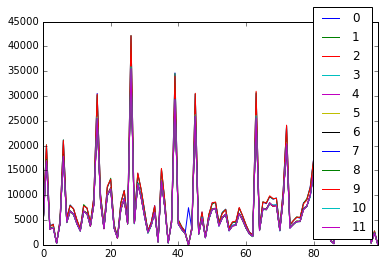

In [58]:
ene.plot()

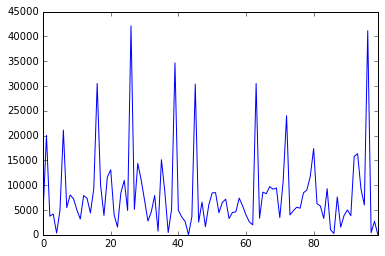

In [59]:
ene[0].plot()

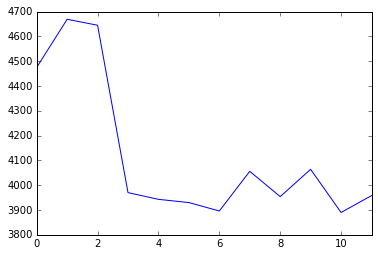

In [60]:
ene.ix[0].plot()